In [ ]:
# Import Libraries

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib
from PIL import Image, ImageChops, ImageEnhance
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Lambda, RepeatVector, Reshape
from numpy import save,load


from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.optimizers import Adam,SGD
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101

from sklearn.metrics import roc_curve, auc,roc_auc_score

from tqdm import tqdm
import cv2

from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
path_original = '/content/drive/MyDrive/dataset/pristine/'
path_tampered = '/content/drive/MyDrive/dataset/fake/'
dataset_path = '/content/drive/MyDrive/dataset/'
total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)


In [ ]:
print('total number of pristine and tampered images are respectively:',len(total_original),',',len(total_tampered))

total number of pristine and tampered images are respectively: 80 , 200


In [ ]:
#saving the path along with the file names
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+i)

In [ ]:
total_tampered[0:5]

['12.jpg', '108.jpg', '1183.jpg', '115.jpg', '1251.jpg']

In [ ]:
def mask_pristine(path):
    img = Image.open(path).convert("RGB")
    img_shape=(np.array(img)).shape
    return np.ones((img_shape))*255

def plot_ground_truth_mask(image,fake=True):
    if fake:
        PATH=path_tampered+image.replace('.mask','')
    else:
        PATH=path_original+image

    PATH_mask=PATH[:-3]+'mask.png'

    img = Image.open(PATH).convert("RGB")

    try:
        mask_img=Image.open(PATH_mask).convert("RGB")
    except:
        mask_img=mask_pristine(PATH)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_title("Image")
    ax2.set_title("Ground Truth Mask")
    ax1.imshow(img)
    ax2.imshow(mask_img)


In [ ]:
'd507e807f025f09ea0cff40b52e9322c.mask.png'.replace('.mask','')[0:-4]

'd507e807f025f09ea0cff40b52e9322c'

200

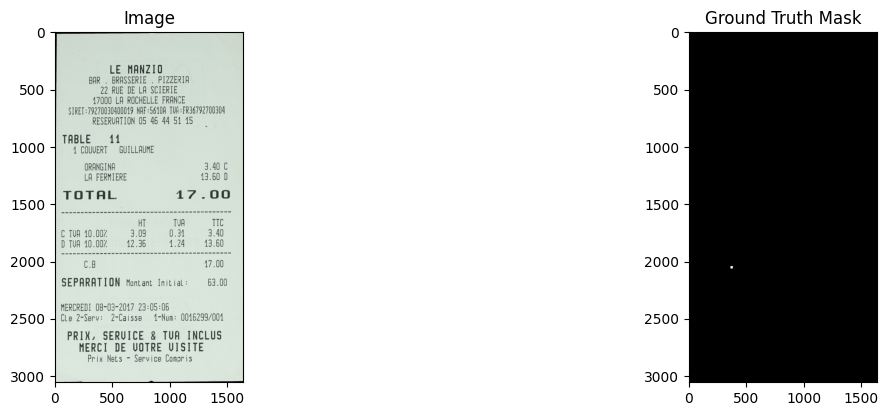

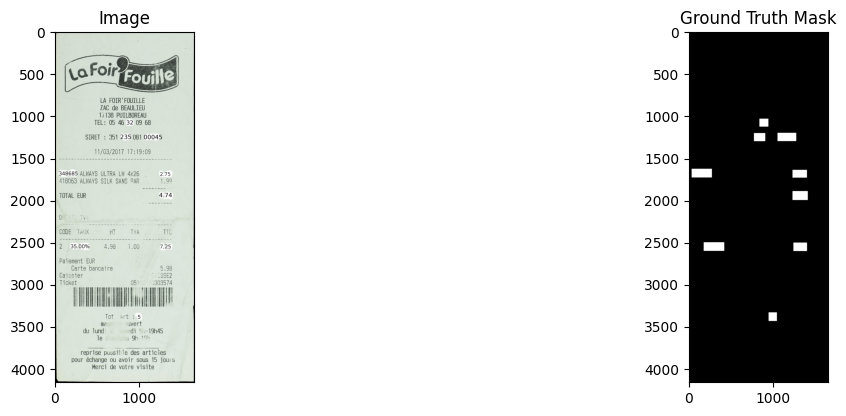

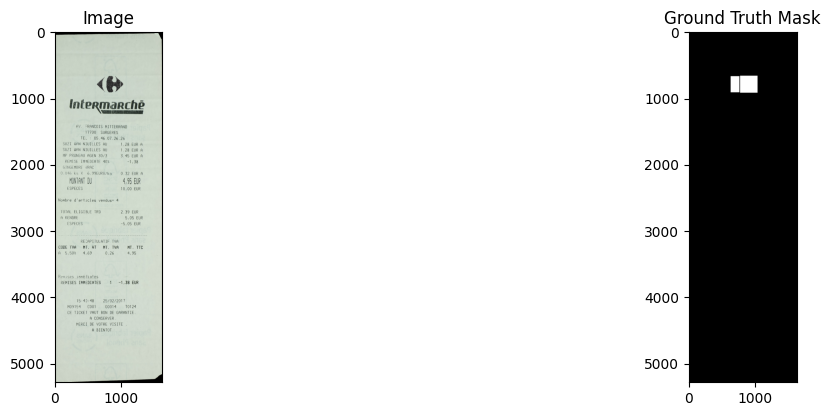

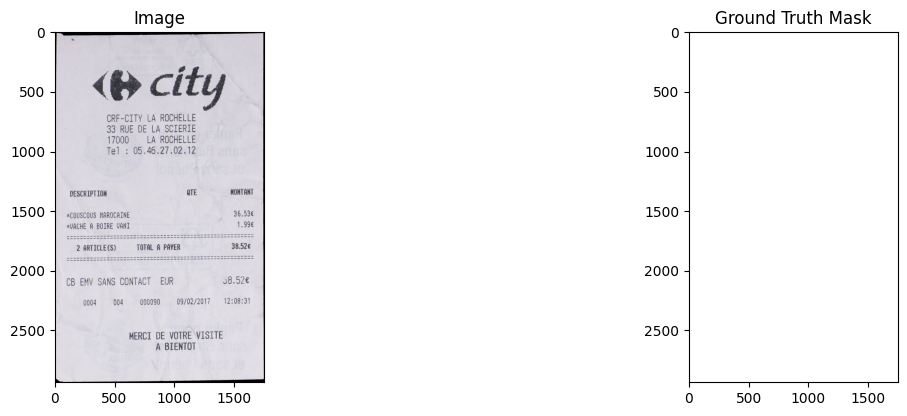

In [ ]:
plot_ground_truth_mask(total_tampered[2])

plot_ground_truth_mask(total_tampered[4])

plot_ground_truth_mask(total_tampered[7])

### Pristine Image

plot_ground_truth_mask(total_original[5],fake=False)

len(total_tampered)

In [ ]:
if not os.path.exists(dataset_path+"resized_images/"):
    os.makedirs(dataset_path+"resized_images/fake_masks/")
    os.makedirs(dataset_path+"resized_images/image/fake_images/")
    os.makedirs(dataset_path+"resized_images/image/pristine_images/")
    height = 512
    width = 512
    for fake_image in tqdm(total_tampered):

        if('.mask' in fake_image):
            img=Image.open(path_tampered + fake_image).convert("RGB")


            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(dataset_path+"resized_images/fake_masks/"+fake_image)
        else:

            img=Image.open(path_tampered + fake_image).convert("RGB")

            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(dataset_path+"resized_images/image/fake_images/"+fake_image)

    for pristine_image in tqdm(total_original):
        img=Image.open(path_original + pristine_image).convert("RGB")

        img = img.resize((height, width), PIL.Image.ANTIALIAS)
        img.save(dataset_path+"resized_images/image/pristine_images/"+pristine_image)


else:
    print('images resized,path exists')

images resized,path exists


In [ ]:
total_tampered.sort()
total_tampered[0]

'1046.jpg'

In [ ]:
len(os.listdir(dataset_path+"resized_images/image/pristine_images/"))
resized_fakes = os.listdir(dataset_path+"resized_images/image/fake_images/")
resized_fake_path = dataset_path+"resized_images/image/fake_images/"
len(resized_fakes)

100

In [ ]:
fakes = total_tampered
fake_path = path_tampered

os.makedirs('processed_images/')

FileExistsError: ignored

In [ ]:
import numpy as np
q = [4.0, 12.0, 2.0]
filter1 = [[0, 0, 0, 0, 0],
           [0, -1, 2, -1, 0],
           [0, 2, -4, 2, 0],
           [0, -1, 2, -1, 0],
           [0, 0, 0, 0, 0]]
filter2 = [[-1, 2, -2, 2, -1],
           [2, -6, 8, -6, 2],
           [-2, 8, -12, 8, -2],
           [2, -6, 8, -6, 2],
           [-1, 2, -2, 2, -1]]
filter3 = [[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, -2, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]]


filter1 = np.asarray(filter1, dtype=float) / q[0]
filter2 = np.asarray(filter2, dtype=float) / q[1]
filter3 = np.asarray(filter3, dtype=float) / q[2]

filters = filter1+filter2+filter3
for x in fakes:
    image = imread(fake_path+x)
    processed_image = cv2.filter2D(image,-1,filters)
    plt.imsave('processed_images/'+x,processed_image)

In [ ]:
processed_images = os.listdir('processed_images/')

In [ ]:
ip_img_filt= []
for i in tqdm(processed_images):
    if('.mask.png' not in i):
#         ip_img_filt.append(resize(imread('processed_images/'+i), (512, 512, 3)))
        ip_img_filt.append('processed_images/'+i)

100%|██████████| 200/200 [00:00<00:00, 282349.65it/s]


In [ ]:
ip_fake_imgs = []
output_imgs = []
for i in tqdm(total_tampered):
    if('.mask.png' not in i):
#         ip_fake_imgs.append(resize(imread(path_tampered+i), (512, 512, 3)))
        ip_fake_imgs.append(path_tampered+i)
    if('.mask.png' in i):
        output_imgs.append(path_tampered+i)
#         output_imgs.append(resize(imread(path_tampered+i), (512, 512, 3)))

100%|██████████| 200/200 [00:00<00:00, 678141.31it/s]


In [ ]:
ip_img_filt.sort();ip_fake_imgs.sort();output_imgs.sort()

In [ ]:
len(ip_img_filt),len(ip_fake_imgs),len(output_imgs)

(100, 100, 100)

In [ ]:
X1_tr = np.array(ip_fake_imgs[0:75])
X2_tr = np.array(ip_img_filt[0:75])
Y_tr = np.array(output_imgs[0:75])

In [ ]:
X1_val = np.array(ip_fake_imgs[75:len(ip_fake_imgs)])
X2_val = np.array(ip_img_filt[75:len(ip_img_filt)])
Y_val = np.array(output_imgs [75:len(output_imgs)])

In [ ]:
X1_tr = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X1_tr])

In [ ]:
X2_tr = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X2_tr])

In [ ]:
Y_tr = np.array([resize(imread(file_name), (512, 512, 1)) for file_name in Y_tr])

In [ ]:
X1_val = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X1_val])

In [ ]:
X2_val = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X2_val])

In [ ]:
Y_val = np.array([resize(imread(file_name), (512, 512, 1)) for file_name in Y_val])

In [ ]:
os.makedirs('/content/drive/MyDrive/dataset/CAD6', exist_ok=True)

In [ ]:
save('/content/drive/MyDrive/dataset/CAD6/X1_tr.npy',X1_tr)

In [ ]:
save('/content/drive/MyDrive/dataset/CAD6/X2_tr.npy',X2_tr)

In [ ]:
save('/content/drive/MyDrive/dataset/CAD6/Y_tr.npy',Y_tr)

In [ ]:
save('/content/drive/MyDrive/dataset/CAD6/X1_val.npy',X1_val)

In [ ]:
save('/content/drive/MyDrive/dataset/CAD6/X2_val.npy',X2_val)

In [ ]:
save('/content/drive/MyDrive/dataset/CAD6/Y_val.npy',Y_val)

In [ ]:
X1_tr = load('/content/drive/MyDrive/dataset/CAD6/X1_tr.npy')

In [ ]:
X2_tr = load('/content/drive/MyDrive/dataset/CAD6/X2_tr.npy')

In [ ]:
Y_tr = load('/content/drive/MyDrive/dataset/CAD6/Y_tr.npy')

In [ ]:
X1_val = load('/content/drive/MyDrive/dataset/CAD6/X1_val.npy')

In [ ]:
X2_val = load('/content/drive/MyDrive/dataset/CAD6/X2_val.npy')

In [ ]:
Y_val = load('/content/drive/MyDrive/dataset/CAD6/Y_val.npy')

In [ ]:
def conv2d_block(input_dim, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same") (input_dim)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(x)
    x = BatchNormalization()(x)
    final_block = Activation("relu")(x)
    return final_block


In [ ]:
input_img = Input((512, 512, 3), name='img1')
n_filters=16
batchnorm=True
dropout=0.5
# contracting path
c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(dropout*0.5)(p1)
c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(dropout)(p2)
c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(dropout)(p3)
c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(dropout)(p4)
c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
#Expanding path
u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
#skip_connections
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

output = Conv2D(3, (1, 1), activation='sigmoid') (c9)
#model1 = Model(inputs=[input_img], outputs=[outputs])

input_img_filter = Input((512, 512, 3), name='img2')
n_filters=16
batchnorm=True
dropout=0.5

# contracting path
c1 = conv2d_block(input_img_filter, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(dropout*0.5)(p1)
c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(dropout)(p2)
c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(dropout)(p3)
c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(dropout)(p4)
c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
#Expanding path
u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
#skip_connections
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

output_filter = Conv2D(3, (1, 1), activation='sigmoid') (c9)

combined = concatenate([output, output_filter])
outputs = Conv2D(1, (1, 1), activation='sigmoid') (combined)


model = Model(inputs=[input_img,input_img_filter], outputs=[outputs])
##model inputs = fake,image and noise filter
## model output = ground truth mask

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img1 (InputLayer)           [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 img2 (InputLayer)           [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['img1[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)          (None, 512, 512, 16)         448       ['img2[0][0]']                
                                                                                              

In [ ]:
def metric(y_true, y_pred, smooth=1): # Dice_Coeff or F-Score
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[metric])

In [ ]:
# with tf.device('/CPU:0'):
#     history = model.fit([X1_tr, X2_tr], [Y_tr],
#                         validation_data=([X1_val, X2_val], [Y_val]),
#                         epochs=30,
#                         batch_size=1,
#                         verbose=1)


In [ ]:
# history = model.fit([X1_tr, X2_tr], [Y_tr],
#                         validation_data=([X1_val, X2_val], [Y_val]),
#                         epochs=30,
#                         batch_size=1,
#                         verbose=1)

In [ ]:
print(X1_tr.shape, X2_tr.shape, Y_tr.shape, X1_val.shape, X2_val.shape, Y_val.shape)

(75, 512, 512, 3) (75, 512, 512, 3) (75, 512, 512, 1) (25, 512, 512, 3) (25, 512, 512, 3) (25, 512, 512, 1)


In [ ]:
from tensorflow.keras.utils import Sequence

class MyDataGenerator(Sequence):
    def __init__(self, X1, X2, Y, batch_size):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X1) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_X1 = self.X1[start:end]
        batch_X2 = self.X2[start:end]
        batch_Y = self.Y[start:end]
        return [batch_X1, batch_X2], batch_Y

data_generator = MyDataGenerator(X1_tr, X2_tr, Y_tr, batch_size=8)
history = model.fit(data_generator, validation_data=([X1_val, X2_val], [Y_val]), epochs=60, verbose=1)


Epoch 1/60
75/75 [==============================] - 94s 713ms/step - loss: 0.2611 - metric: 0.0184 - val_loss: 0.3112 - val_metric: 0.0437
Epoch 2/60
75/75 [==============================] - 12s 155ms/step - loss: 0.1434 - metric: 0.0167 - val_loss: 0.1433 - val_metric: 0.0363
Epoch 3/60
75/75 [==============================] - 11s 149ms/step - loss: 0.1007 - metric: 0.0159 - val_loss: 0.1287 - val_metric: 0.0362
Epoch 4/60
75/75 [==============================] - 11s 149ms/step - loss: 0.0815 - metric: 0.0167 - val_loss: 0.1175 - val_metric: 0.0336
Epoch 5/60
75/75 [==============================] - 11s 151ms/step - loss: 0.0711 - metric: 0.0189 - val_loss: 0.1175 - val_metric: 0.0343
Epoch 6/60
75/75 [==============================] - 11s 152ms/step - loss: 0.0646 - metric: 0.0232 - val_loss: 0.1165 - val_metric: 0.0359
Epoch 7/60
75/75 [==============================] - 12s 159ms/step - loss: 0.0613 - metric: 0.0225 - val_loss: 0.1170 - val_metric: 0.0378
Epoch 8/60
75/75 [=========

In [ ]:
model.save('/content/drive/MyDrive/srm_filter.h5')

In [ ]:
# from keras.models import load_model

# # Define your custom metric function
# def metric_function(y_true, y_pred):
#     # Your metric implementation
#     return metric_value

# # Load the model with the custom metric function
# model = load_model('/content/drive/MyDrive/srm_filter.h5', custom_objects={'metric': metric_function})


dict_keys(['loss', 'metric', 'val_loss', 'val_metric'])


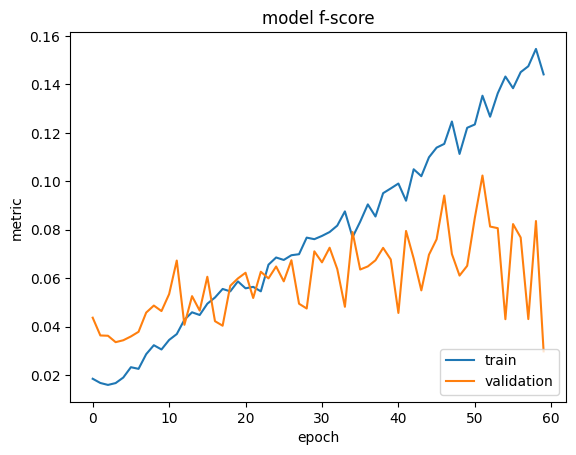

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['metric'])
plt.plot(history.history['val_metric'])
plt.title('model f-score')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()


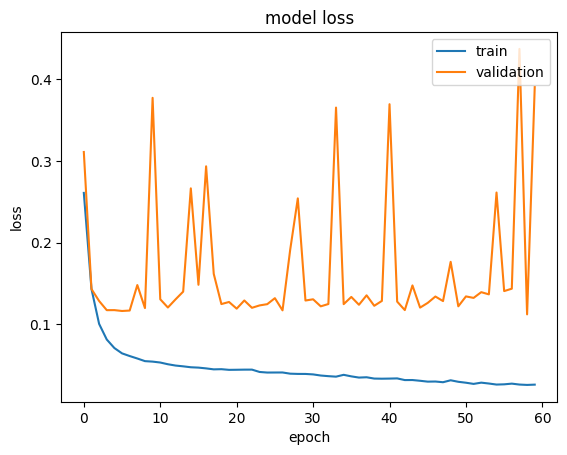

In [ ]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

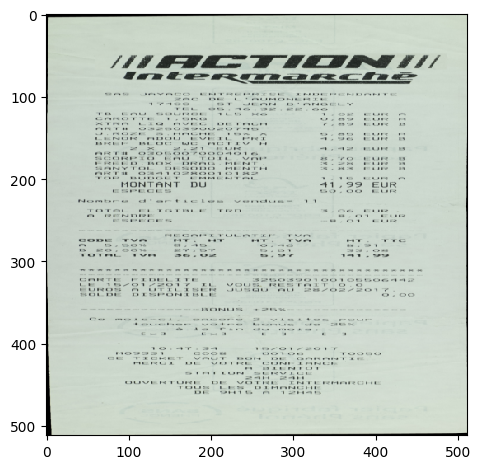

In [ ]:
imshow(X1_val[1])

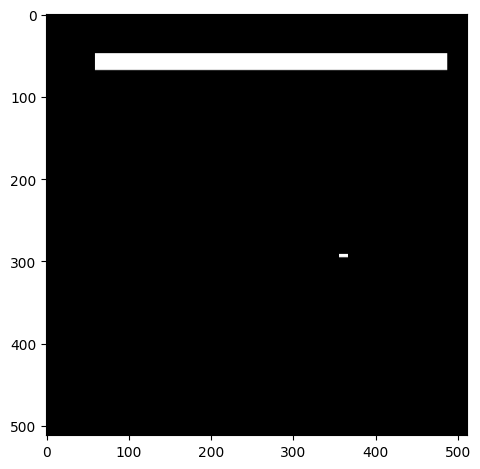

In [ ]:
#https://stackoverflow.com/questions/54664329/invalid-dimension-for-image-data-in-plt-imshow
imshow(np.squeeze(Y_val[1]))

In [ ]:
prediction = model.predict([X1_val,X2_val])

1/1 [==============================] - 1s 916ms/step


In [ ]:
prediction

array([[[[0.00187081],
         [0.00176715],
         [0.00171487],
         ...,
         [0.00160493],
         [0.00167369],
         [0.00162504]],

        [[0.00167076],
         [0.00162528],
         [0.00154655],
         ...,
         [0.00155059],
         [0.00156127],
         [0.00158699]],

        [[0.0016968 ],
         [0.00160614],
         [0.001538  ],
         ...,
         [0.00156524],
         [0.00156228],
         [0.00154357]],

        ...,

        [[0.00166316],
         [0.00157497],
         [0.00156858],
         ...,
         [0.00155982],
         [0.00160044],
         [0.00162334]],

        [[0.00185376],
         [0.00176063],
         [0.00162054],
         ...,
         [0.001638  ],
         [0.0016722 ],
         [0.00163617]],

        [[0.0017843 ],
         [0.00168323],
         [0.00169893],
         ...,
         [0.0016273 ],
         [0.00169253],
         [0.00171451]]],


       [[[0.00178367],
         [0.00165625],
         [0.00

In [ ]:
def plot_predicted_images(index):
    """Plots the predicted masks of tampered images"""
    pred = np.squeeze(prediction[index])
    plt.imsave('pred_mask.png',pred)
    im_gray = cv2.imread('pred_mask.png', cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 220, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)


    ax1.set_title("actual_image")
    ax2.set_title("actual_mask")
    ax3.set_title("predicted_mask")
    ax1.imshow(X1_val[index])
    ax2.imshow(np.squeeze(Y_val[index]))
    ax3.imshow(im_bw)

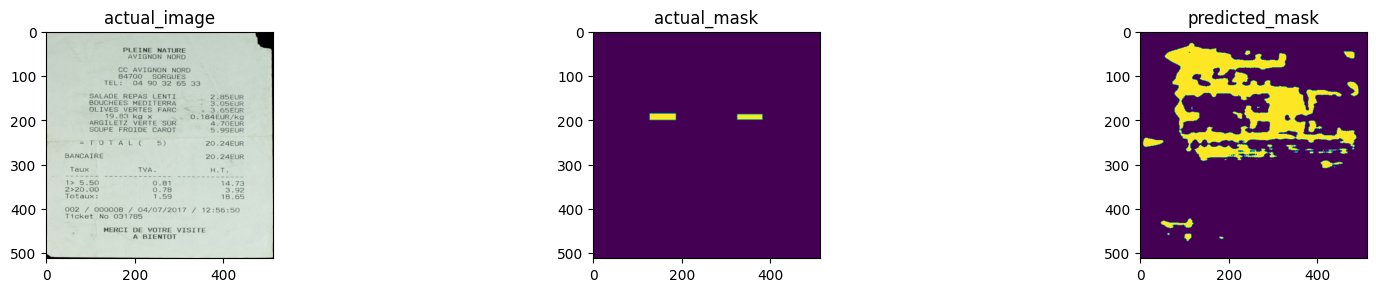

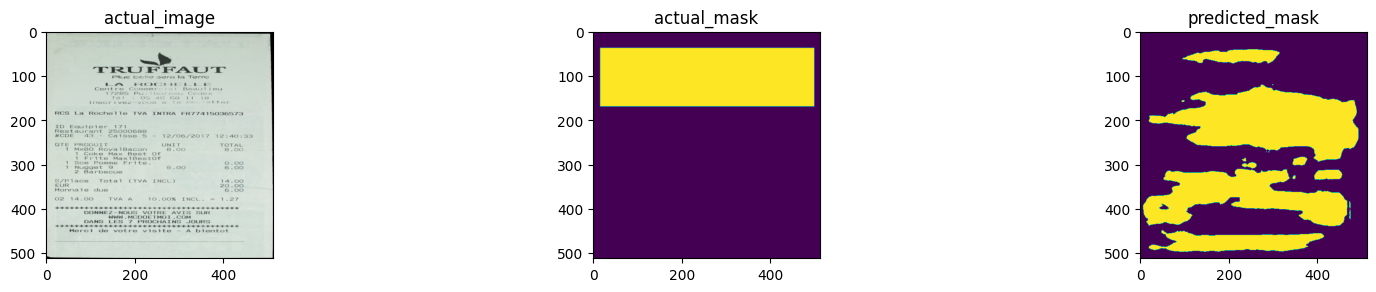

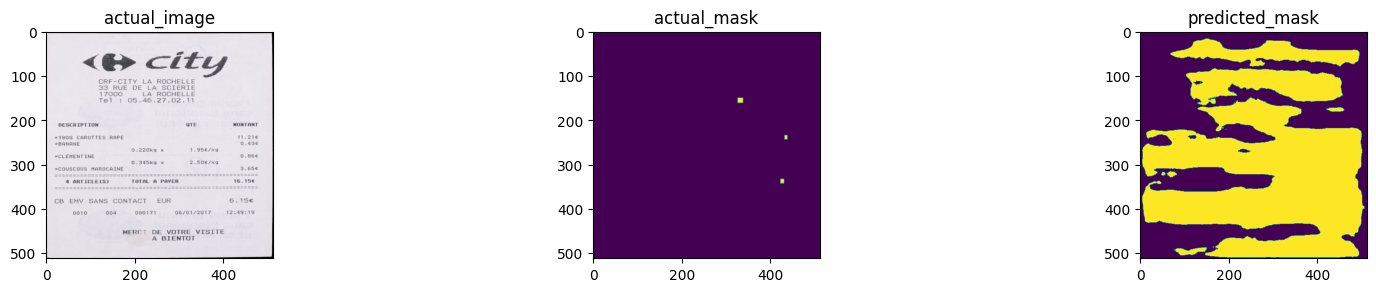

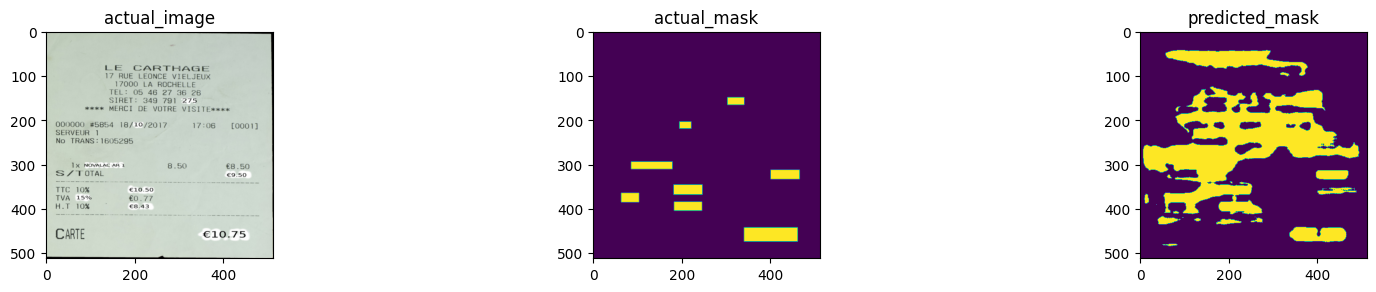

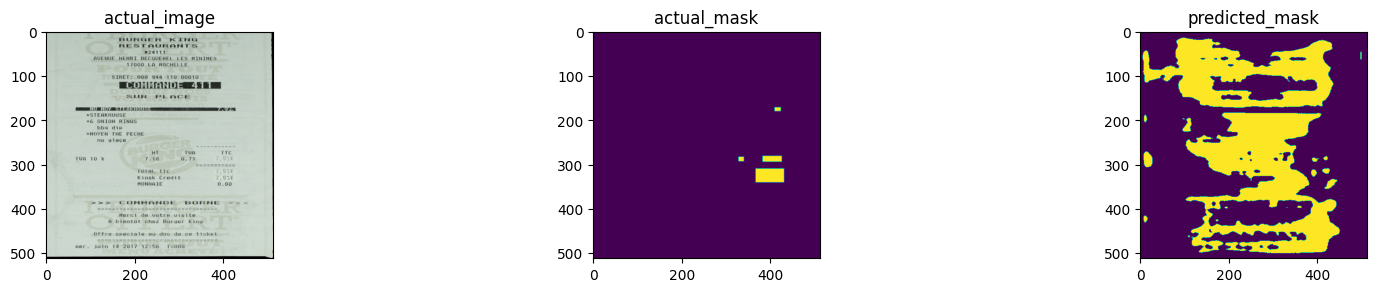

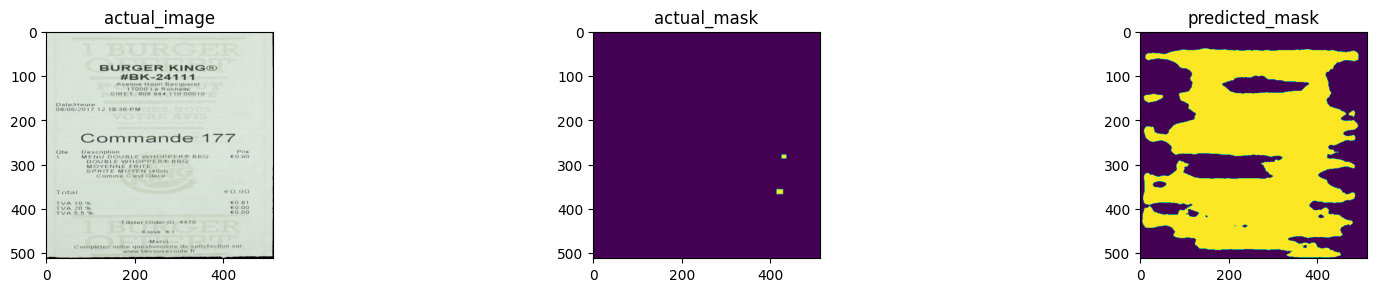

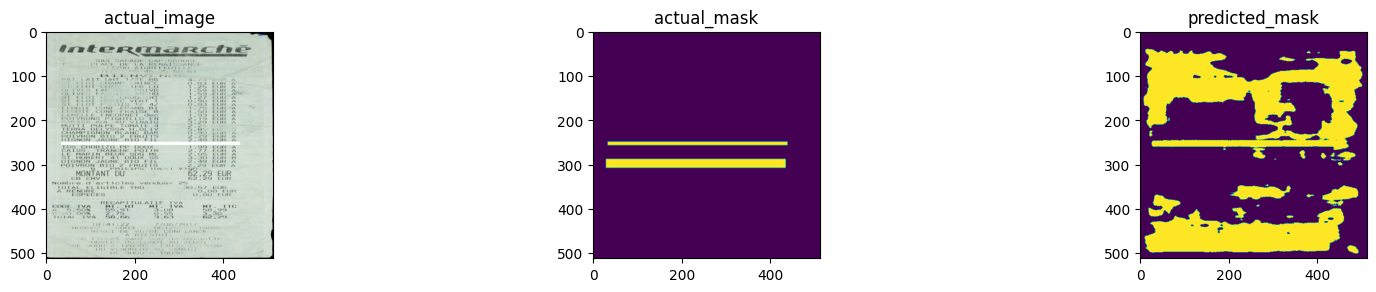

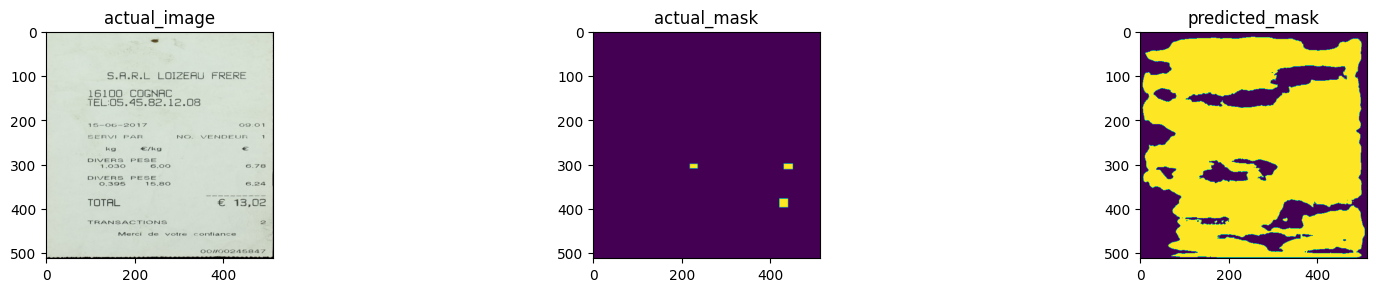

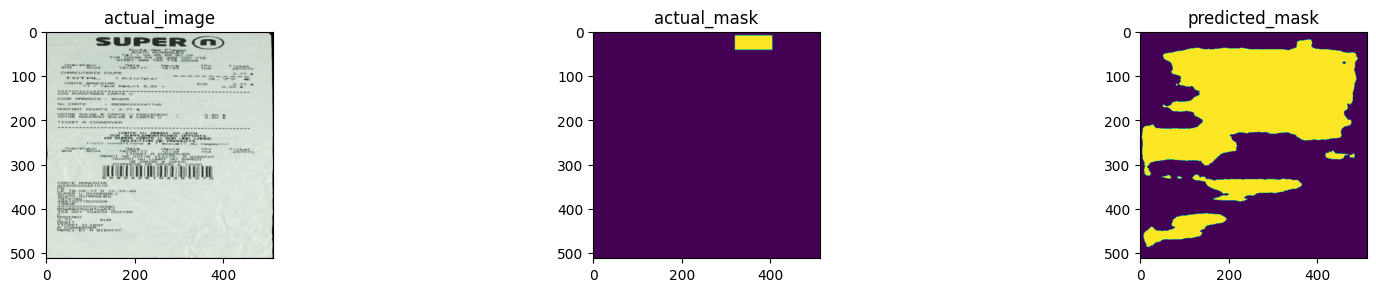

In [ ]:
plot_predicted_images(10)

plot_predicted_images(11)

plot_predicted_images(12)

plot_predicted_images(13)

plot_predicted_images(14)

plot_predicted_images(15)

plot_predicted_images(16)

plot_predicted_images(17)

plot_predicted_images(18)